# Track Record

This notebook is used to determine the performance of a forecast on the market for the last 8 years. The following rules apply:

- Starting budget: 10.000€
- One buy/sell (short selling) per month with the total available budget.
- Forecasts are made at the beginning of the year using all previous data as context.

<br><br>
This notebook contains a comparison of models to asses the effect of using the GDelt data as related time series.<br>
The models are trained up to 6 years ago to predict the next 6 years, each taking in the entire available context for inference, when forecasting the next period of 52 weeks. One model is trained with GDelt as related time series and the other one is not. Besides that, they are identical.

In [1]:
# Add the repo to the python paths if not yet existing there - for the data_engineering input
import sys
import os

repo_path = os.getcwd().split('project_submission_haiperformer')[0] + 'project_submission_haiperformer'
sys.path.append(repo_path) if repo_path not in sys.path else None

In [2]:
# Imports
import pandas as pd
from data_engineering.src.util.track_record_helpers import get_df_from_Sample_Forecast

c:\Users\janhe\Desktop\Uni\Data Exploration Project\project_submission_haiperformer\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In the following cell, we can choose between one training and taking the model to forecast the next 8 years or re-training every year to forecast the next one for the last 6 years.


In [3]:
# Import forecasts and get single time series from it for the model using GDelt
forecast_list_gdelt = pd.read_pickle(
    "../../modelling/backtests/8_windows/v5/8year_test_forecasts.pkl"
)
forecast_df_gdelt = pd.DataFrame()

for forecast in forecast_list_gdelt:
    df = get_df_from_Sample_Forecast(forecast)
    forecast_df_gdelt = pd.concat((forecast_df_gdelt, df), axis=0)

forecast_df_gdelt["forecast_mean"] = forecast_df_gdelt.mean(axis=1)
forecast_df_gdelt.drop(axis=1, columns=list(range(100)), inplace=True)
forecast_df_gdelt.head(450)

,forecast_mean
2015-06-08,2128.038574
2015-06-15,2132.137939
2015-06-22,2135.332520
2015-06-29,2143.436768
2015-07-06,2146.945557
...,...
2023-04-24,3565.853516
2023-05-01,3528.875244
2023-05-08,3520.271484
2023-05-15,3508.763184


In [4]:
# Import forecasts and get single time series from it for the model NOT using GDelt
forecast_list_no_gdelt = pd.read_pickle(
    "../../modelling/backtests/8_windows/without GDELT/take 1/8year_test_forecasts.pkl"
)
forecast_df_no_gdelt = pd.DataFrame()

for forecast in forecast_list_no_gdelt:
    df = get_df_from_Sample_Forecast(forecast)
    forecast_df_no_gdelt = pd.concat((forecast_df_no_gdelt, df), axis=0)

forecast_df_no_gdelt["forecast_mean"] = forecast_df_no_gdelt.mean(axis=1)
forecast_df_no_gdelt.drop(axis=1, columns=list(range(100)), inplace=True)
forecast_df_no_gdelt.head(450)

,forecast_mean
2015-06-08,2126.245117
2015-06-15,2115.452393
2015-06-22,2110.512451
2015-06-29,2116.117432
2015-07-06,2109.919678
...,...
2023-04-24,3172.304443
2023-05-01,3170.351318
2023-05-08,3160.261230
2023-05-15,3132.329590


In [5]:
# Import the actual time series
indices_df = pd.read_csv("../financial_ts/indices.csv", index_col=0)
snp_series = indices_df["S&P"]
snp_series

1971-02-08        NaN
1971-02-15        NaN
1971-02-22        NaN
1971-03-01        NaN
1971-03-08        NaN
               ...   
2023-04-24    4132.07
2023-05-01    4166.79
2023-05-08    4136.98
2023-05-15    4126.65
2023-05-22    4190.78
Name: S&P, Length: 2729, dtype: float64

This creates a track record where we buy or sell (short-selling) for the next 4 weeks depending on the movement of the forecast in that period. All available budget is taken at all times.


In [6]:
# Set input parameters for the track record calculation
budget = 10000
risk_factor = 1
trading_interval = 4

#### Using the model trained with GDelt

In [7]:
# Calculate track record
track_record_gdelt = pd.DataFrame(
    columns=["Date", "Action", "Forecast", "Actual", "Return (%)", "Budget", "LongOnly"]
)
track_record_gdelt["Date"] = forecast_df_gdelt.index
track_record_gdelt["Forecast"] = forecast_df_gdelt["forecast_mean"].values
track_record_gdelt["Actual"] = snp_series.values[-forecast_df_gdelt.shape[0] :]

# Set the LongOnly strategy column
norm_factor = track_record_gdelt.at[0, "Actual"] / budget
track_record_gdelt["LongOnly"] = track_record_gdelt["Actual"] / norm_factor

# Calculate monthly returns and track record
for i in range(0, len(track_record_gdelt), trading_interval):
    # Get the forecasted movemnt within the next 4 weeks
    forecasted_change = (
        track_record_gdelt["Forecast"].iloc[i + trading_interval - 1]
        - track_record_gdelt["Forecast"].iloc[i]
    ) / track_record_gdelt["Forecast"].iloc[i]
    actual_change = (
        track_record_gdelt["Actual"].iloc[i + trading_interval - 1]
        - track_record_gdelt["Actual"].iloc[i]
    ) / track_record_gdelt["Actual"].iloc[i]
    actual_change = (
        0 if pd.isna(actual_change) else actual_change
    )  # Do not trade when index data is missing

    if forecasted_change > 0:
        action = "Buy"
        budget *= 1 + risk_factor * actual_change
    else:
        action = "Sell"
        budget *= 1 - risk_factor * actual_change

    action = "Nothing" if actual_change == 0 else action

    # Update the track record DataFrame
    track_record_gdelt.at[i, "Action"] = action
    track_record_gdelt.at[i, "Return (%)"] = actual_change
    track_record_gdelt.at[i, "Budget"] = budget

# Print the track record
track_record_gdelt.to_csv("../../documentation/track_record_gdelt.csv", index=False)
print(track_record_gdelt.head(420))

          Date Action     Forecast   Actual Return (%)        Budget   
0   2015-06-08    Buy  2128.038574  2092.34   0.003006  10030.062036  \
1   2015-06-15    NaN  2132.137939  2091.34        NaN           NaN   
2   2015-06-22    NaN  2135.332520  2112.50        NaN           NaN   
3   2015-06-29    NaN  2143.436768  2098.63        NaN           NaN   
4   2015-07-06    Buy  2146.945557  2073.95   0.002044  10050.567575   
..         ...    ...          ...      ...        ...           ...   
411 2023-04-24    NaN  3565.853516  4132.07        NaN           NaN   
412 2023-05-01   Sell  3528.875244  4166.79   0.005757     5671.7317   
413 2023-05-08    NaN  3520.271484  4136.98        NaN           NaN   
414 2023-05-15    NaN  3508.763184  4126.65        NaN           NaN   
415 2023-05-22    NaN  3484.627197  4190.78        NaN           NaN   

         LongOnly  
0    10000.000000  
1     9995.220662  
2    10096.351453  
3    10030.062036  
4     9912.107975  
..            .

#### Using the model trained without GDelt

In [8]:
# Reset input parameters for the track record calculation
budget = 10000
risk_factor = 1
trading_interval = 4

In [9]:
# Calculate track record
track_record_no_gdelt = pd.DataFrame(
    columns=["Date", "Action", "Forecast", "Actual", "Return (%)", "Budget", "LongOnly"]
)
track_record_no_gdelt["Date"] = forecast_df_no_gdelt.index
track_record_no_gdelt["Forecast"] = forecast_df_no_gdelt["forecast_mean"].values
track_record_no_gdelt["Actual"] = snp_series.values[-forecast_df_no_gdelt.shape[0] :]

# Set the LongOnly strategy column
norm_factor = track_record_no_gdelt.at[0, "Actual"] / budget
track_record_no_gdelt["LongOnly"] = track_record_no_gdelt["Actual"] / norm_factor

# Calculate monthly returns and track record
for i in range(0, len(track_record_no_gdelt), trading_interval):
    # Get the forecasted movemnt within the next 4 weeks
    forecasted_change = (
        track_record_no_gdelt["Forecast"].iloc[i + trading_interval - 1]
        - track_record_no_gdelt["Forecast"].iloc[i]
    ) / track_record_no_gdelt["Forecast"].iloc[i]
    actual_change = (
        track_record_no_gdelt["Actual"].iloc[i + trading_interval - 1]
        - track_record_no_gdelt["Actual"].iloc[i]
    ) / track_record_no_gdelt["Actual"].iloc[i]
    actual_change = (
        0 if pd.isna(actual_change) else actual_change
    )  # Do not trade when index data is missing

    if forecasted_change > 0:
        action = "Buy"
        budget *= 1 + risk_factor * actual_change
    else:
        action = "Sell"
        budget *= 1 - risk_factor * actual_change

    action = "Nothing" if actual_change == 0 else action

    # Update the track record DataFrame
    track_record_no_gdelt.at[i, "Action"] = action
    track_record_no_gdelt.at[i, "Return (%)"] = actual_change
    track_record_no_gdelt.at[i, "Budget"] = budget

# Print the track record
track_record_no_gdelt.to_csv("../../documentation/track_record_no_gdelt.csv", index=False)
print(track_record_no_gdelt.head(420))

          Date Action     Forecast   Actual Return (%)       Budget   
0   2015-06-08   Sell  2126.245117  2092.34   0.003006  9969.937964  \
1   2015-06-15    NaN  2115.452393  2091.34        NaN          NaN   
2   2015-06-22    NaN  2110.512451  2112.50        NaN          NaN   
3   2015-06-29    NaN  2116.117432  2098.63        NaN          NaN   
4   2015-07-06   Sell  2109.919678  2073.95   0.002044  9949.555343   
..         ...    ...          ...      ...        ...          ...   
411 2023-04-24    NaN  3172.304443  4132.07        NaN          NaN   
412 2023-05-01   Sell  3170.351318  4166.79   0.005757  5001.736472   
413 2023-05-08    NaN  3160.261230  4136.98        NaN          NaN   
414 2023-05-15    NaN  3132.329590  4126.65        NaN          NaN   
415 2023-05-22    NaN  3112.175049  4190.78        NaN          NaN   

         LongOnly  
0    10000.000000  
1     9995.220662  
2    10096.351453  
3    10030.062036  
4     9912.107975  
..            ...  
411  19

## Track record analysis

Further analysis on top of the track record


In [10]:
import matplotlib.pyplot as plt

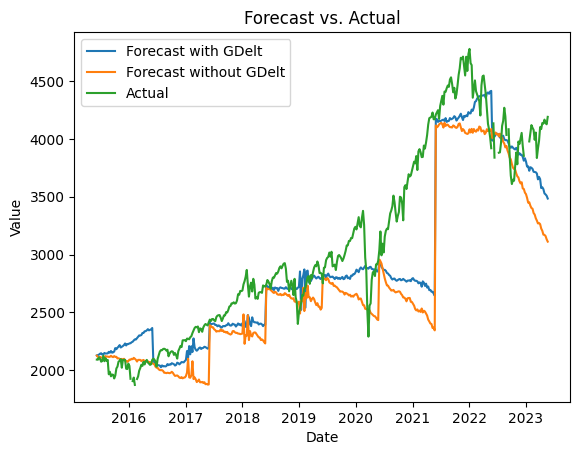

In [11]:
# Forecasted S&P 500 vs actual index data
plt.plot(track_record_gdelt["Date"], track_record_gdelt["Forecast"], label="Forecast with GDelt")
plt.plot(track_record_no_gdelt["Date"], track_record_no_gdelt["Forecast"], label="Forecast without GDelt")
plt.plot(track_record_gdelt["Date"], track_record_gdelt["Actual"], label="Actual")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Forecast vs. Actual")
plt.legend()
plt.show()

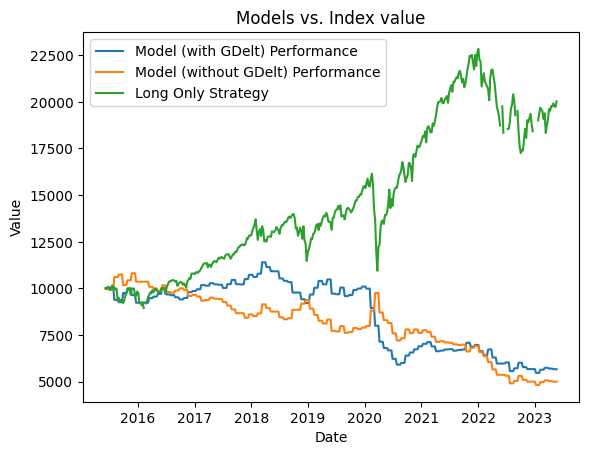

In [12]:
# Plot the models track record vs. a long only strategy (just investing once in the beginning).
plt.plot(
    track_record_gdelt["Date"],
    track_record_gdelt["Budget"].interpolate(method="pad"),
    label="Model (with GDelt) Performance",
)
plt.plot(
    track_record_no_gdelt["Date"],
    track_record_no_gdelt["Budget"].interpolate(method="pad"),
    label="Model (without GDelt) Performance",
)
plt.plot(track_record_gdelt["Date"], track_record_gdelt["LongOnly"], label="Long Only Strategy")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Models vs. Index value")
plt.legend()
plt.show()

In [13]:
print(f"Value counts for the actions with GDelt: \n{track_record_gdelt['Action'].value_counts()}")
print(f"Value counts for the actions without GDelt: \n{track_record_no_gdelt['Action'].value_counts()}")

Value counts for the actions with GDelt: 
Action
Buy        52
Sell       48
Nothing     4
Name: count, dtype: int64
Value counts for the actions without GDelt: 
Action
Sell       79
Buy        21
Nothing     4
Name: count, dtype: int64
